In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
fname = '/net/jam-amaro-shared/dse_project/Spike_Dataset/TRAJECTORIES_spike_open_prot_glyc_amarolab/results/FinalExtractedFeature_open.csv'
open_df = pd.read_csv(fname).assign(label = 1).iloc[:,1:]

In [3]:
print(f'open dcd size : {open_df.shape}')
open_df.head()

open dcd size : (42222, 221)


,Frame Num,frame,RBD_CA0:ROF,RBD_CA0:RMSD,RBD__2__CH_CA0,CH_CA0:ROF,CH_CA0:RMSD,RBD__2__GLY0,GLY0:ROF,GLY0:RMSD,...,RBD__2__GLY8,GLY8:ROF,GLY8:RMSD,RBD__2__GLY9,GLY9:ROF,GLY9:RMSD,RBD__2__backbone0,backbone0:ROF,backbone0:RMSD,label
0,0,frame_0,2.146310,0.135435,8.696114,2.430049,0.073119,6.597967,1.519505,0.309062,...,17.516027,2.425352,0.294207,20.553479,1.791446,0.278311,7.953154,7.455652,0.138682,1
1,1,frame_1,2.141260,0.170498,8.610321,2.452126,0.070816,6.323298,1.377560,0.281506,...,17.493029,2.410283,0.346432,20.551318,1.787035,0.402983,7.894130,7.443351,0.165635,1
2,2,frame_2,2.131270,0.153697,8.592710,2.430950,0.079461,6.274642,1.494150,0.237929,...,17.299496,2.297616,0.433491,20.409004,1.919100,0.455504,7.841270,7.439311,0.179153,1
3,3,frame_3,2.126830,0.181805,8.590594,2.439935,0.073912,6.287297,1.520262,0.246225,...,17.104382,2.345125,0.363078,20.299202,1.932984,0.360417,7.843353,7.431243,0.204023,1
4,4,frame_4,2.132262,0.173935,8.585232,2.446247,0.075612,6.173709,1.459852,0.213698,...,17.266876,2.344855,0.299472,20.380623,1.847637,0.358222,7.848105,7.426812,0.220511,1


In [4]:
def restrict_RBD_window(df,nm):
    '''Function to drop features of dataframe that correspond to glycans which are outside a given RBD neighborhood (in nm)'''
    #Get list of glycans
    glycans = list(np.unique([x.replace('RBD__2__','') for x in df.keys().to_list() if 'RBD__2__GLY' in x]))
    
    for g in glycans:
        if df['RBD__2__' + g].mean() > nm:
            df.drop(['RBD__2__'+g,g+':ROF',g+':RMSD'],axis=1,inplace=True)
            
    return df
    #for each glycan, if avg RBD__2__GLY distance > nm, drop that feature and other related features

In [5]:
fname = '/net/jam-amaro-shared/dse_project/Spike_Dataset/TRAJECTORIES_spike_closed_prot_glyc_amarolab/results/FinalExtractedFeature_closed.csv'
closed_df = pd.read_csv(fname).assign(label = 0).iloc[:,1:]

In [6]:
print(f'closed dcd size : {closed_df.shape}')
closed_df.head()

closed dcd size : (17314, 221)


,Frame Num,frame,RBD_CA0:ROF,RBD_CA0:RMSD,RBD__2__CH_CA0,CH_CA0:ROF,CH_CA0:RMSD,RBD__2__GLY0,GLY0:ROF,GLY0:RMSD,...,RBD__2__GLY8,GLY8:ROF,GLY8:RMSD,RBD__2__GLY9,GLY9:ROF,GLY9:RMSD,RBD__2__backbone0,backbone0:ROF,backbone0:RMSD,label
0,0,frame_0,2.064992,0.104537,7.011860,2.440622,0.071946,8.272009,1.753118,0.256231,...,15.816480,2.131665,0.296665,18.712970,2.230321,0.390132,6.132472,7.333359,0.137631,0
1,1,frame_1,2.082220,0.142265,7.059966,2.451281,0.067347,8.274339,1.777587,0.298775,...,15.865187,2.082916,0.267647,18.565217,2.212942,0.319875,6.172430,7.338856,0.161682,0
2,2,frame_2,2.079883,0.168931,7.061981,2.428138,0.075575,8.126430,1.926069,0.304831,...,15.789881,2.140586,0.278618,18.491900,2.070410,0.297723,6.154211,7.331262,0.173915,0
3,3,frame_3,2.105020,0.156687,7.035488,2.423324,0.076875,8.221630,1.901495,0.362107,...,15.844295,2.129400,0.294769,18.489304,2.043514,0.243517,6.143025,7.325061,0.189567,0
4,4,frame_4,2.107028,0.128242,6.968371,2.426547,0.086771,8.170091,1.940600,0.308735,...,15.790533,2.163263,0.299083,18.452190,2.221308,0.352847,6.106590,7.313821,0.198229,0


In [7]:
# Load mutant data as well
fname = '/net/jam-amaro-shared/dse_project/Spike_Dataset/TRAJECTORIES_spike_mutant_prot_glyc_amarolab.tar.gz/results/FinalExtractedFeature_mutant.csv'
mutant_df = pd.read_csv(fname).assign(label=1)

In [8]:
# Only use glycans within 10 nm of the RBD
open_df = restrict_RBD_window(open_df,8)
closed_df = restrict_RBD_window(closed_df,8)
mutant_df = restrict_RBD_window(mutant_df,8)

In [98]:
common_cols = set(open_df.columns.to_list()).intersection(closed_df.columns.intersection(mutant_df.columns.to_list()))
full_df = open_df.loc[:,common_cols].append(closed_df.loc[:,common_cols]).drop(['frame','Frame Num'],axis=1)
full_df.shape

/tmp/ipykernel_31592/2113978704.py:2: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.

/tmp/ipykernel_31592/2113978704.py:2: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.

/tmp/ipykernel_31592/2113978704.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



(59536, 51)

## Looking for Correlations

In [99]:
corr_matrix = full_df.corr()
corr_thresh = 0.5 #original was 0.65
final_features = corr_matrix['RBD_CA0:RMSD'][(corr_matrix['RBD_CA0:RMSD'] < corr_thresh) & (corr_matrix['RBD_CA0:RMSD'] > -corr_thresh)].reset_index().loc[:,'index'].to_list()
clf_df = full_df.loc[:,final_features]

In [100]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(clf_df,test_size=0.3, random_state=42,stratify=full_df.label)
print(f'Train set : {train_set.shape}, Test set : {test_set.shape}')

Train set : (41675, 48), Test set : (17861, 48)


In [104]:
train_set.keys().to_list()

['GLY14:ROF',
 'CH_CA0:ROF',
 'RBD__2__GLY11',
 'RBD__2__GLY35',
 'GLY4:ROF',
 'GLY0:ROF',
 'GLY11:ROF',
 'GLY24:ROF',
 'GLY35:ROF',
 'GLY13:RMSD',
 'RBD__2__GLY14',
 'RBD__2__GLY24',
 'backbone0:RMSD',
 'RBD__2__GLY1',
 'GLY1:RMSD',
 'RBD__2__GLY13',
 'RBD__2__GLY51',
 'backbone0:ROF',
 'GLY0:RMSD',
 'GLY12:RMSD',
 'RBD__2__GLY4',
 'CH_CA0:RMSD',
 'RBD__2__GLY2',
 'RBD__2__CH_CA0',
 'GLY12:ROF',
 'GLY35:RMSD',
 'GLY44:RMSD',
 'GLY14:RMSD',
 'GLY1:ROF',
 'GLY11:RMSD',
 'GLY23:RMSD',
 'label',
 'GLY4:RMSD',
 'RBD__2__GLY3',
 'GLY2:ROF',
 'GLY51:ROF',
 'RBD__2__GLY44',
 'GLY13:ROF',
 'GLY24:RMSD',
 'RBD__2__GLY12',
 'GLY3:ROF',
 'GLY44:ROF',
 'RBD__2__GLY23',
 'GLY51:RMSD',
 'RBD__2__GLY0',
 'RBD_CA0:ROF',
 'RBD__2__backbone0',
 'GLY23:ROF']

# Prepare the Data for Machine Learning Algorithms

In [76]:
import plotly.express as px
import time

In [77]:
train_X = train_set.drop("label", axis=1) # drop labels for training set
train_labels = train_set["label"].copy()
train_X.shape,train_labels.shape

((41675, 47), (41675,))

In [78]:
test_X = test_set.drop("label", axis=1) # drop labels for training set
test_labels = test_set["label"].copy()
test_X.shape, test_labels.shape

((17861, 47), (17861,))

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
       ('std_scaler', StandardScaler()),
    ])

train_X_prepared = num_pipeline.fit_transform(train_X)
test_X_prepared = num_pipeline.transform(test_X)

In [80]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=100, tol=1e-3, random_state=42)

In [81]:
from sklearn.model_selection import cross_val_score,cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,train_X_prepared, train_labels, cv=10)
t = time.time()
cross_val_score(sgd_clf, train_X_prepared, train_labels, cv=10, scoring="accuracy")
#print(str(time.time()-t) + ' sec elapsed')

array([1.        , 1.        , 1.        , 0.99976008, 1.        ,
       0.99976002, 1.        , 1.        , 1.        , 1.        ])

In [96]:
mutant_df.loc[:,common_cols].drop(["frame","Frame Num"],axis=1).head()

/tmp/ipykernel_31592/1371081159.py:1: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



,GLY14:ROF,CH_CA0:ROF,RBD__2__GLY11,RBD__2__GLY35,GLY4:ROF,GLY0:ROF,GLY11:ROF,GLY2:RMSD,GLY24:ROF,GLY35:ROF,...,RBD__2__GLY12,GLY3:ROF,GLY44:ROF,RBD__2__GLY23,GLY51:RMSD,RBD_CA0:RMSD,RBD__2__GLY0,RBD_CA0:ROF,RBD__2__backbone0,GLY23:ROF
0,3.940404,2.447579,6.569449,7.140739,3.990095,1.521675,1.892873,0.176374,3.525652,8.127645,...,4.513751,3.780843,4.858304,8.082208,0.301478,0.124956,6.221800,2.178091,7.879317,3.314490
1,3.887662,2.459875,6.436003,7.059873,3.964416,1.508451,1.888832,0.186999,3.561052,8.078441,...,4.299195,3.846762,4.826632,8.130166,0.406105,0.149543,6.122916,2.149317,7.772753,3.321046
2,3.858432,2.461492,6.403536,7.108533,3.915510,1.539993,1.758411,0.300124,3.585452,8.088689,...,4.353259,3.830398,4.773883,8.208106,0.292461,0.171919,6.110341,2.143670,7.822148,3.326981
3,3.865545,2.444338,6.411707,7.169412,3.989322,1.565013,1.750813,0.266255,3.512377,8.065538,...,4.502183,3.878491,4.755619,8.336375,0.363304,0.169495,6.299373,2.134737,7.861003,3.344971
4,3.937735,2.433935,6.299086,7.095213,4.064872,1.540981,1.806611,0.216212,3.520783,8.072303,...,4.390307,3.867792,4.788616,8.313508,0.418656,0.186895,5.990773,2.153319,7.904470,3.286622


In [110]:
val_X = num_pipeline.transform(mutant_df.loc[:,train_set.keys().to_list()].drop(["label"],axis=1))
val_labels = mutant_df["label"].copy()
y_val_pred = sgd_clf.predict(val_X)
print(f' Val precison : {precision_score(val_labels, y_val_pred)}, Val recall {recall_score(val_labels, y_val_pred)}')


 Val precison : 1.0, Val recall 1.0


## Precision and Recall

In [82]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
confusion_matrix(train_labels, y_train_pred)
print(f' Train precison : {precision_score(train_labels, y_train_pred)}, train recall {recall_score(train_labels, y_train_pred)}')

 Train precison : 0.999932334134046, train recall 1.0


In [83]:
sgd_clf.fit(train_X_prepared,train_labels)
y_test_pred = sgd_clf.predict(test_X_prepared)
print(f' Test precison : {precision_score(test_labels, y_test_pred)}, Test recall {recall_score(test_labels, y_test_pred)}')
px.bar(x=train_X.columns.to_list(),y=sgd_clf.coef_[0],color=sgd_clf.coef_[0],labels={'x':'Feature','y':'Importance','color':'Importance'}).update_xaxes(categoryorder='total ascending')

 Test precison : 0.9998421343436735, Test recall 1.0


In [54]:
sgd_clf.coef_[0][train_X.columns.to_list().index('RBD__2__GLY40')]

ValueError: 'RBD__2__GLY40' is not in list

In [ ]:
train_X.columns.to_list().index('RBD__2__backbone0')

In [ ]:
train_X.keys()

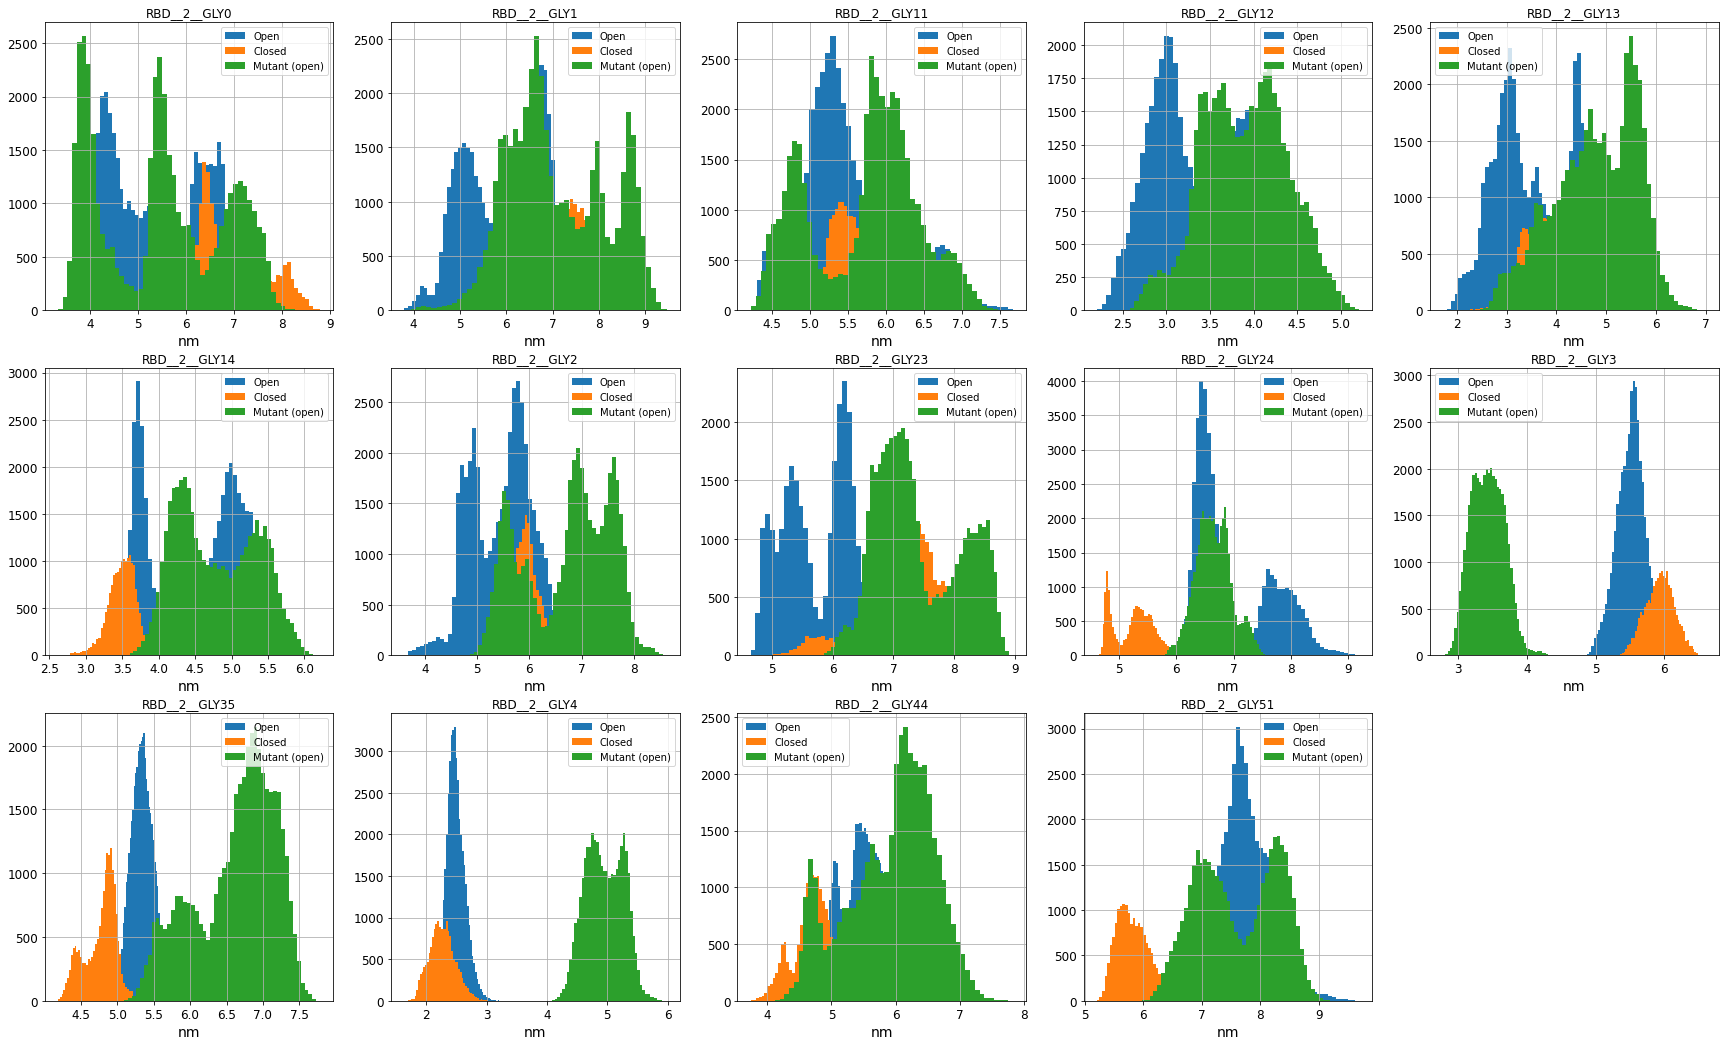

In [60]:
import matplotlib.pyplot as plt

feat = 'RBD__2__GLY51'
def overlapping_hist(open_df,closed_df,feat):
    open_df[feat].hist(bins=50)
    closed_df[feat].hist(bins=50)
    mutant_df[feat].hist(bins=50)
    plt.legend(['Open','Closed','Mutant (open)'])
    plt.title(feat)
    if 'RBD__2__' in feat:
        plt.xlabel('nm')

feats = list(np.unique([x for x in train_set.keys().to_list() if 'RBD__2__GLY' in x]))        
#feats = ['RBD__2__GLY51','RBD__2__GLY24','RBD__2__GLY14','RBD__2__GLY3']   
#feats = ['GLY22:ROF','RBD__2__CH_CA0','RBD__2__backbone0','RBD__2__GLY32','RBD__2__GLY51']
plt.figure(figsize=(30,18))
for i in range(len(feats)):
    plt.subplot(3,5,i+1)
    overlapping_hist(open_df,closed_df,feats[i])

In [ ]:
train_X.hist(bins=50, figsize=(20,15))